In [1]:
# importing required modules

import os
import sys
import numpy as np

from readSemEval2014_BIO import get_BIO

import sys


In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Dropout
from keras.layers import LSTM, Embedding, TimeDistributed, Bidirectional
from keras.models import Model
from keras.initializers import Constant

Using TensorFlow backend.


In [5]:
from keras_contrib.layers import CRF
from keras.layers import merge
from keras.layers import concatenate

In [6]:
def read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM):
    
    with open(os.path.join(GLOVE_DIR, 'glove.6B.'+str(EMBEDDING_DIM)+'d.txt')) as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [7]:
def preprocess(file):
    
    X, Y = get_BIO(xml_file=file)
    sentence_length = [len(x) for x in X]
    
#     #______create vocab
#     flatten_corpus = [x for y in X for x in y]
#     vocab = set(flatten_corpus)
#     vocab.add('')
    
    return X, Y, max(sentence_length)

In [8]:
def generate_data_for_keras(X, Y, BIO_index, word_index, return_validation = False):

    sequences = []
    for mykeys in X:
        sequences.append([word_index[x] if x in word_index.keys() else 0 for x in mykeys])
    #sequences.append([word_index[x] for x in mykeys])
        
    labels = []
    for mykeys in Y:
        labels.append([BIO_index[x] for x in mykeys])
        
    # padding 
    # long sentences truncated to maxlen (last sequences are kept)
    # short sentences padded with 0 (pad are added at begining)
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  
    pad_labels = pad_sequences(labels, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  
    
    
    # converting to one-hot representation
    cat_labels = to_categorical(np.asarray(pad_labels))
    
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', cat_labels.shape)
    
    if return_validation:
        # split the data into a training set and a validation set
        indices = np.arange(data.shape[0])
        np.random.shuffle(indices)
        data = data[indices]
        cat_labels = cat_labels[indices]

        num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
        x_train = data[:-num_validation_samples]
        y_train = cat_labels[:-num_validation_samples] 
        x_val = data[-num_validation_samples:]
        y_val = cat_labels[-num_validation_samples:]
        return x_train, y_train, x_val, y_val
    
    else:
        x_train = data
        y_train = cat_labels

        return x_train, y_train


In [53]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, random_term):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map[random_term].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index] = embedding_vector

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. 
    # Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [10]:
def get_aspect_terms(labels, input_tokens):
    aspect_list = []
    asp = None
    for ind, val in enumerate(labels):
        next_ind = ind+1
        
        if asp is None:
            asp = '<UNK>'
        if next_ind < len(labels):
            if val == 1 and labels[next_ind] == 0: 
                aspect_list.append(input_tokens[ind])
            elif val == 1 and labels[next_ind] == 2:
                asp = input_tokens[ind]
            elif val == 2 :
                asp = asp+' '+ input_tokens[ind]  
                if not labels[next_ind] == 2:
                    aspect_list.append(asp)
        else:
            if val == 1:
                aspect_list.append(input_tokens[ind])
            elif val ==2:
                asp = asp+' '+ input_tokens[ind]  
                aspect_list.append(asp)

    return aspect_list

In [11]:
def get_text_n_aspect_4_xml(tokens, binary_label):

    pos = 0
    from_ = 0
    tuple_ = []
    asp = None
    for ind, (bit, token) in enumerate(zip(binary_label,tokens)):
        
        next_ind = ind+1
        
        if asp is None:
            asp = '<UNK>'
        if next_ind < len(binary_label):
            if bit == 1 and binary_label[next_ind] == 0: 
                from_ = pos
                aspect = token
                to_ = from_ + len(aspect)
                tuple_.append((aspect, from_, to_))
                
            elif bit == 1 and binary_label[next_ind] == 2:
                from_ = pos
                asp = token
            elif bit == 2 :
                asp = asp+' '+ token  
                if not binary_label[next_ind] == 2:
                    aspect = asp
                    to_ = from_ + len(aspect)
                    tuple_.append((aspect, from_, to_))
                    
        else:
            if bit == 1:
                from_ = pos
                aspect = token
                to_ = from_ + len(aspect)
                tuple_.append((aspect, from_, to_))
                
            elif bit ==2:
                asp = asp+' '+ token 
                aspect = asp
                to_ = from_ + len(aspect)
                tuple_.append((aspect, from_, to_))
                
        pos = pos + len(token)+ 1 # plus 1 for space
        import sys

    return ' '.join(tokens), tuple_

In [12]:
def predict_results(model, x_in, y, vocab_list):   
    
    xml_content_predict = []
    xml_content_actual = []
    
    y_argmax = np.argmax(y, axis=-1)
    
    x = x_in
 
        
    res_argmax = np.argmax(model.predict(x_in), axis=-1)
#     x_tokens = vocab_list[x]
    
    for k, (actual_label, predicted_label) in enumerate(zip(y_argmax, res_argmax)):
        
        tokens = vocab_list[0, x[k]]
#         print(actual_label)
#         print(predicted_label)
        actual_aspect_list = get_aspect_terms(actual_label, tokens)
        predicted_aspect_list = get_aspect_terms(predicted_label, tokens)

#         print(tokens)
        
#         print(actual_aspect_list)
#         print(predicted_aspect_list)
        
        xml_content_predict.append(get_text_n_aspect_4_xml(tokens, predicted_label))
        xml_content_actual.append(get_text_n_aspect_4_xml(tokens, actual_label))
#         print('\n________________________________\n')
        
    return xml_content_predict, xml_content_actual

In [13]:
def write_in_xml(filename, content):
    
    import xml.etree.ElementTree as ET

    root = ET.Element('sentences')

    for i, con in enumerate(content):
        
        sentence = ET.SubElement(root, 'sentence')
        sentence.set('id', str(i))
        text_tag = ET.SubElement(sentence, 'text')
        text_tag.text = con[0]
    
        aspectTerms = ET.SubElement(sentence, 'aspectTerms')
        
        tuple_ = con[1]
        for t in tuple_:
            aspect, from_, to_ = t[0], t[1], t[2]
            
            aspectTerm = ET.SubElement(aspectTerms, 'aspectTerm')
            aspectTerm.set('from',str(from_))
            aspectTerm.set('to',str(to_))
#             aspectTerm.set('polarity','positive')
            aspectTerm.set('term',aspect)

#     print(ET.tostring(root))

    ET.ElementTree(root).write(filename+'.xml', xml_declaration=True, encoding='utf-8', method="xml")

In [54]:
GLOVE_DIR = './Word2Vec'
EMBEDDING_DIM = 100
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(GLOVE_DIR, EMBEDDING_DIM)

In [55]:
vocab_list = np.empty(shape=(1,len(word_to_index)+1), dtype='<U68')
vocab_list[0,1:] = np.array(list(word_to_index.keys()))

In [56]:
VALIDATION_SPLIT = 0.2
BIO_index = {'O':0, 'B':1, 'I':2} 


In [57]:
domain_name = 'Laptops' # 'Laptops' 'Restaurants'

if domain_name == 'Restaurants':
    training_file='Data/Restaurants_Train_v2.xml'
    testing_file = 'Data/Restaurants_Test_Data_phaseB.xml'
else:
    training_file='Data/Laptop_Train_v2.xml'
    testing_file = 'Data/Laptops_Test_Data_phaseB.xml' 

In [58]:
X, Y, MAX_SEQUENCE_LENGTH = preprocess(file=training_file)
# x_train, y_train, x_val, y_val = generate_data_for_keras(X, Y, BIO_index, word_to_index, return_validation = TRUE)
x_train, y_train  = generate_data_for_keras(X, Y, BIO_index, word_to_index)

Shape of data tensor: (3045, 83)
Shape of label tensor: (3045, 83, 3)


In [59]:
X_test, Y_test, _ = preprocess(file=testing_file)
# x_test, y_test, _, _ = generate_data_for_keras(X_test, Y_test, BIO_index, word_to_index)
x_test, y_test = generate_data_for_keras(X_test, Y_test, BIO_index, word_to_index)

Shape of data tensor: (800, 83)
Shape of label tensor: (800, 83, 3)


In [67]:
import keras.backend as K
embedding_layer_words = pretrained_embedding_layer(word_to_vec_map, word_to_index, "cucumber")

In [68]:
sequence_input_words = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences_words = embedding_layer_words(sequence_input_words)

In [103]:
x = Bidirectional(LSTM(128, return_sequences=True))(embedded_sequences_words)
#x = LSTM(128, return_sequences=True)(embedded_sequences_words)

x = Dropout(0.2)(x)

In [104]:
################# Softmax Layer ####################
pre = TimeDistributed(Dense(len(BIO_index), activation='softmax'))(x)

crf = CRF(3)

preds = crf(pre)

model = Model(inputs=sequence_input_words , outputs=preds)
model.compile(loss= crf.loss_function,
              optimizer='rmsprop',
              metrics=[crf.accuracy])
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 83)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 83, 100)           40000100  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 83, 256)           234496    
_________________________________________________________________
dropout_7 (Dropout)          (None, 83, 256)           0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 83, 3)             771       
_________________________________________________________________
crf_17 (CRF)                 (None, 83, 3)             27        
Total params: 40,235,394
Trainable params: 235,294
Non-trainable params: 40,000,100
__________________________________________________________

In [108]:
epochs_count = 20# 50

In [109]:
mi = model.fit(x_train, 
          y_train,
          batch_size=128,
          epochs=epochs_count,
         validation_split =VALIDATION_SPLIT)

Train on 2436 samples, validate on 609 samples
Epoch 1/20
2436/2436 [==============================] - 16s 7ms/step - loss: 0.1588 - crf_viterbi_accuracy: 0.9864 - val_loss: 0.1514 - val_crf_viterbi_accuracy: 0.9857
Epoch 2/20
2436/2436 [==============================] - 21s 9ms/step - loss: 0.1428 - crf_viterbi_accuracy: 0.9864 - val_loss: 0.1373 - val_crf_viterbi_accuracy: 0.9857
Epoch 3/20
2436/2436 [==============================] - 20s 8ms/step - loss: 0.1299 - crf_viterbi_accuracy: 0.9864 - val_loss: 0.1259 - val_crf_viterbi_accuracy: 0.9857
Epoch 4/20
2436/2436 [==============================] - 20s 8ms/step - loss: 0.1194 - crf_viterbi_accuracy: 0.9864 - val_loss: 0.1168 - val_crf_viterbi_accuracy: 0.9857
Epoch 5/20
2436/2436 [==============================] - 21s 8ms/step - loss: 0.1111 - crf_viterbi_accuracy: 0.9864 - val_loss: 0.1096 - val_crf_viterbi_accuracy: 0.9857
Epoch 6/20
2436/2436 [==============================] - 21s 9ms/step - loss: 0.1045 - crf_viterbi_accuracy: 

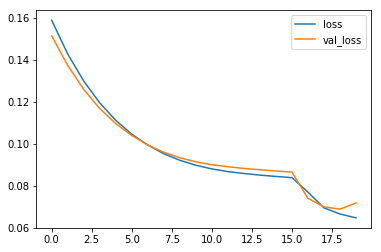

In [110]:
import matplotlib.pyplot as plt
plt.plot(mi.history['loss'],label='loss')
plt.plot(mi.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

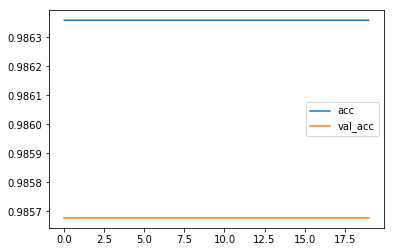

In [112]:
plt.plot(mi.history['crf_viterbi_accuracy'],label='acc')
plt.plot(mi.history['val_crf_viterbi_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [113]:
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.9839909648895264


In [115]:
xml_content_predict, xml_content_actual = predict_results(model, x_train, y_train, vocab_list)
write_in_xml(domain_name +'_Bmodel1_ATE_'+ 'train_'+str(epochs_count)+'_predict_result', xml_content_predict)
write_in_xml(domain_name +'_Bmodel1_ATE_'+ 'train_'+str(epochs_count)+'_actual_result', xml_content_actual)

xml_content_predict, xml_content_actual = predict_results(model, x_test, y_test, vocab_list)
write_in_xml(domain_name +'_Bmodel1_ATE_'+ 'test_'+str(epochs_count)+'_predict_result', xml_content_predict)
write_in_xml(domain_name +'_Bmodel1_ATE_'+ 'test_'+str(epochs_count)+'_actual_result', xml_content_actual)

In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 83)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 83, 100)           40000100  
_________________________________________________________________
lstm_5 (LSTM)                (None, 83, 128)           117248    
_________________________________________________________________
dropout_5 (Dropout)          (None, 83, 128)           0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 83, 3)             387       
_________________________________________________________________
crf_15 (CRF)                 (None, 83, 3)             27        
Total params: 40,117,762
Trainable params: 117,662
Non-trainable params: 40,000,100
__________________________________________________________